# 결과

+ best1(mae: 1.507) non-scaling ridge(alpha = 10)
+ best2(mae : 1.508) non-scaling elasticnet(alpha = 0.01) -> 변수추가
+ best3(mae:   1.5481) : non-scaling elasticnet(alpha = 1)이 가장 결과가 좋았다
+ R에서 뽑은 변수들만 출력 :10개

["crm_clue_고소","crm_clue_현행범","vic_sx_2","vic_age_60세초과","cctv_개수","배치인원_수","비상벨_개수","일인가구수","기초수급_19세이하","외국인수", "score_절폭"]

In [1]:
import pandas as pd

#그래프에 한글 표현하기
import  matplotlib.pyplot as plt
import  matplotlib.font_manager as fm
import  matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = "C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family = font_name)



#마이너스 표시하기
import  matplotlib as mlp
mlp.rcParams["axes.unicode_minus"]  = False

import numpy as np
import pandas  as pd
import seaborn as sns
##회귀분석
import statsmodels.api as sm
# 정규화
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import  RFE
from lightgbm import LGBMClassifier,  LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import multiprocessing 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression
from scipy import stats
#사용법이 파이선과 다른 기존xgb를  파이선에 맞게 만들어 놓은 것
from  xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import RobustScaler

#변수영향도 그래프, 트리그래프 더 쉽게 그리게 해줌
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("../완성본_안전도_회귀분석/1_절도폭력안전도.csv")

In [3]:
# #R에서 뽑은 변수들만 출력 8개
# df = df[["crm_wthr_폭설","crm_clue_고소","crm_clue_현행범","vic_age_60세초과"
#     ,"배치인원_수","비상벨_개수","기초수급_19세이하","외국인수","score_절폭"]]

In [4]:
#R에서 뽑은 변수들만 출력 :10개
# 추가 : crm_wthr_바람 , crm_clue_피해자신고
df = df[["crm_wthr_바람","crm_clue_피해자신고","crm_clue_고소","crm_clue_현행범","vic_sx_2","vic_age_60세초과","cctv_개수",
         "배치인원_수","비상벨_개수",
        "일인가구수","기초수급_19세이하","외국인수", "score_절폭"]]

In [5]:
df

,crm_wthr_바람,crm_clue_피해자신고,crm_clue_고소,crm_clue_현행범,vic_sx_2,vic_age_60세초과,cctv_개수,배치인원_수,비상벨_개수,일인가구수,기초수급_19세이하,외국인수,score_절폭
0,1.0,4224.0,148.0,774.0,1912.0,318.0,4719,395,5.0,52811.0,39101,15295,78.30
1,0.0,2729.0,91.0,409.0,1063.0,297.0,2919,258,1.0,28612.0,39101,24040,70.10
2,0.0,3048.0,143.0,850.0,1413.0,484.0,4447,333,8.0,41116.0,39101,18967,73.40
3,1.0,1431.0,111.0,170.0,658.0,243.0,1218,185,11.0,20165.0,54889,4184,73.15
4,0.0,1047.0,73.0,72.0,446.0,218.0,913,142,12.0,21519.0,54889,3268,77.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,914.0,94.0,277.0,487.0,239.0,1855,176,499.0,24317.0,31361,7111,75.80
119,0.0,2700.0,163.0,585.0,1402.0,555.0,4469,406,1778.0,52196.0,46485,9785,71.85
120,0.0,1377.0,84.0,468.0,683.0,271.0,1563,236,339.0,18597.0,6833,11496,77.40
121,1.0,841.0,63.0,333.0,449.0,238.0,784,213,42.0,41063.0,5756,10641,74.60


<AxesSubplot:>

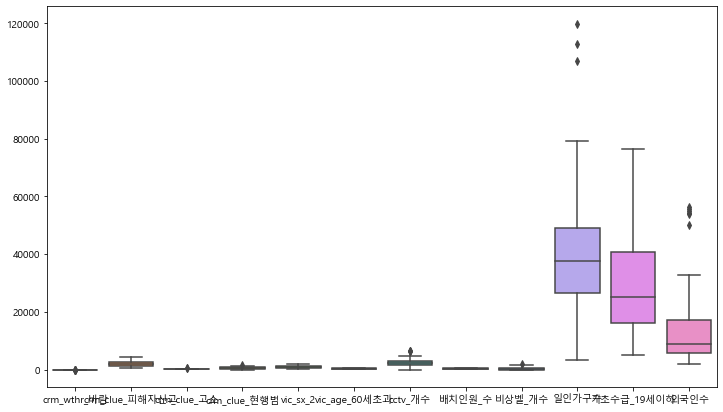

In [5]:
#이상치 확인
#극단값을  갖는  모습을 볼 수 있다 ->robustscale하면  좋을  듯  하다
plt.figure(figsize = (12,7))
sns.boxplot(data = df.iloc[:,:-1])

# 설명력 보기위한 모델링

In [5]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_절폭"],test_size = 0.3, random_state=0)

# ridge, lasso, elasticnet을 위한 alpha값 찾기 함수

In [6]:
def alphas_finder(model):
    alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    for alpha in alphas:
        modeling = model(alpha=alpha)
        modeling.fit(X_train, y_train)
        print(alpha , ":" ,round(modeling.score(X_train, y_train),3)
              , round(modeling.score(X_test, y_test),3)
              ,"mae:",round(mean_absolute_error(modeling.predict(X_test), y_test),3))    

# 교차검증

In [7]:
X = np.array(df.drop('score_절폭', 1))
Y = np.array(df['score_절폭'])

In [8]:
from sklearn.model_selection import KFold

#kfold 설정
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True,random_state=0)

#mae kfold 교차검증 함수
def mae_kfold(model):
    i = 1
    total_error = 0
    for train_index, test_index in kfold.split(X):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]
        model_pred_fold = model.fit(x_train_fold, y_train_fold).predict(x_test_fold)
        error = mean_absolute_error(model_pred_fold, y_test_fold)
        print('Fold = {}, mae = {:.2f}'.format(i, error))
        total_error += error
        i+=1
    print('---'*10)
    print('Average Error: %s' % (total_error / n_splits))
    print('---'*10)

# 모델링

## 1. None scaling

In [11]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.653230433101919 0.6578287408749123 1.5773330851018483


In [12]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.35
Fold = 2, mae = 1.59
Fold = 3, mae = 1.50
Fold = 4, mae = 1.83
Fold = 5, mae = 1.56
------------------------------
Average Error: 1.5669085161780814
------------------------------


## ridge

In [13]:
# ridge
alphas_finder(Ridge)

100 : 0.653 0.663 mae: 1.565
10 : 0.653 0.659 mae: 1.576
1 : 0.653 0.658 mae: 1.577
0.1 : 0.653 0.658 mae: 1.577
0.01 : 0.653 0.658 mae: 1.577
0.001 : 0.653 0.658 mae: 1.577
0.0001 : 0.653 0.658 mae: 1.577


In [8]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.33
Fold = 2, mae = 1.62
Fold = 3, mae = 1.37
Fold = 4, mae = 1.75
Fold = 5, mae = 1.53
------------------------------
Average Error: 1.521106647783995
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.52
------------------------------
Average Error: 1.5075273238352587
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.5080502639713802
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.508107044538015
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.508112771769579
-----------------------------

In [9]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

Ridge(alpha=10)

In [22]:
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef').reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'], color = "orange", alpha = 0.8)
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    
    #plt.show()
    

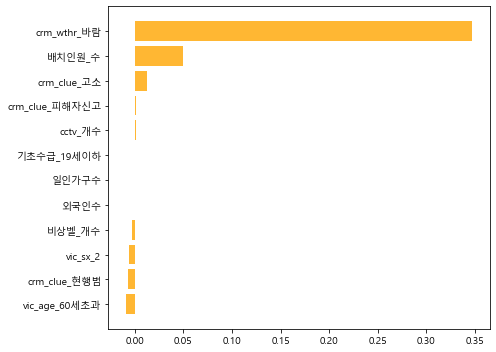

In [23]:
plot_coef(X_train.columns  , ridge.coef_)
plt.savefig('../이미지/변수영향도_절도폭력안전도.png', dpi=200,bbox_inches='tight')

<BarContainer object of 12 artists>

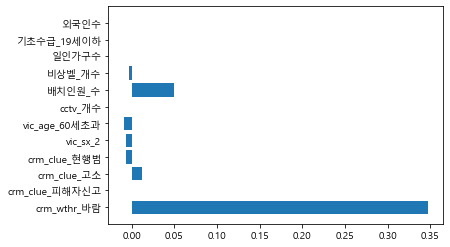

In [18]:
x = X_train.columns
y =  ridge.coef_
plt.barh(x , y )

## Lasso

In [15]:
# lasso
alphas_finder(Lasso)

100 : 0.381 0.477 mae: 2.088
10 : 0.627 0.652 mae: 1.615
1 : 0.648 0.674 mae: 1.549
0.1 : 0.653 0.663 mae: 1.566
0.01 : 0.653 0.658 mae: 1.576
0.001 : 0.653 0.658 mae: 1.577
0.0001 : 0.653 0.658 mae: 1.577


In [16]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 1.94
Fold = 2, mae = 2.29
Fold = 3, mae = 1.67
Fold = 4, mae = 2.46
Fold = 5, mae = 1.97
------------------------------
Average Error: 2.0680123963656483
------------------------------
Fold = 1, mae = 1.47
Fold = 2, mae = 1.67
Fold = 3, mae = 1.43
Fold = 4, mae = 1.89
Fold = 5, mae = 1.64
------------------------------
Average Error: 1.6209993753697742
------------------------------
Fold = 1, mae = 1.33
Fold = 2, mae = 1.60
Fold = 3, mae = 1.48
Fold = 4, mae = 1.84
Fold = 5, mae = 1.55
------------------------------
Average Error: 1.5626103838589716
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.59
Fold = 3, mae = 1.49
Fold = 4, mae = 1.84
Fold = 5, mae = 1.56
------------------------------
Average Error: 1.5641902155628968
------------------------------
Fold = 1, mae = 1.35
Fold = 2, mae = 1.59
Fold = 3, mae = 1.50
Fold = 4, mae = 1.83
Fold = 5, mae = 1.56
------------------------------
Average Error: 1.5663002422247876
--------------------------

## ElasticNet

In [17]:
alphas_finder(ElasticNet)

100 : 0.416 0.496 mae: 1.999
10 : 0.643 0.666 mae: 1.574
1 : 0.648 0.674 mae: 1.546
0.1 : 0.653 0.661 mae: 1.571
0.01 : 0.653 0.658 mae: 1.577
0.001 : 0.653 0.658 mae: 1.577
0.0001 : 0.653 0.658 mae: 1.577


In [18]:
#best : 1.5481
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.89
Fold = 2, mae = 2.12
Fold = 3, mae = 1.84
Fold = 4, mae = 2.39
Fold = 5, mae = 1.94
------------------------------
Average Error: 2.037951883875928
------------------------------
Fold = 1, mae = 1.39
Fold = 2, mae = 1.62
Fold = 3, mae = 1.46
Fold = 4, mae = 1.85
Fold = 5, mae = 1.58
------------------------------
Average Error: 1.577604622907386
------------------------------
Fold = 1, mae = 1.33
Fold = 2, mae = 1.60
Fold = 3, mae = 1.49
Fold = 4, mae = 1.84
Fold = 5, mae = 1.55
------------------------------
Average Error: 1.5619734724833922
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.59
Fold = 3, mae = 1.50
Fold = 4, mae = 1.84
Fold = 5, mae = 1.56
------------------------------
Average Error: 1.5651736218967947
------------------------------
Fold = 1, mae = 1.35
Fold = 2, mae = 1.59
Fold = 3, mae = 1.50
Fold = 4, mae = 1.83
Fold = 5, mae = 1.56
------------------------------
Average Error: 1.5665831833935875
----------------------------

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11400632151605805, tolerance: 0.10729462500000009
  model = cd_fast.enet_coordinate_descent(


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,1.7,crm_wthr_바람
1,273.5,crm_clue_피해자신고
2,11.9,crm_clue_고소
3,25.6,crm_clue_현행범
4,393.0,vic_sx_2
5,27.0,vic_age_60세초과
6,7.4,cctv_개수
7,79.5,배치인원_수
8,3.3,비상벨_개수
9,22.0,일인가구수


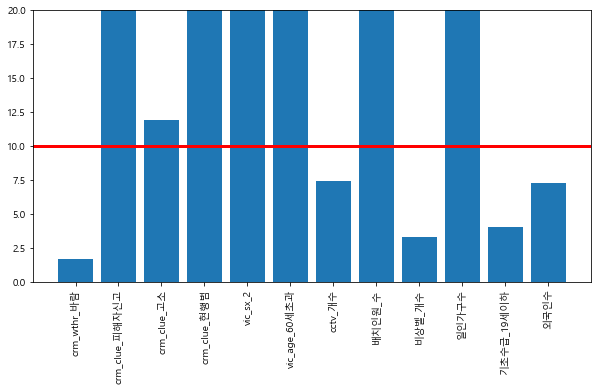

In [52]:
plt.figure(figsize = (10,5))
x = vif["features"]
y = vif["VIF Factor"]
plt.bar(x, y)
plt.ylim(0,20)
plt.xticks(rotation=90)
plt.axhline(y=10, color='r', linewidth=3)
plt.savefig('../이미지/다중공산성.png', dpi=200,bbox_inches='tight') 


<Figure size 432x288 with 0 Axes>

## XGboost

In [16]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999261627908 0.6899261886089127 1.5486931053367832


In [17]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.36
Fold = 2, mae = 1.88
Fold = 3, mae = 1.73
Fold = 4, mae = 2.18
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.8276949030558267
------------------------------


In [18]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999567863228 0.5401282505859426 1.973513134105786


In [19]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.74
Fold = 2, mae = 1.63
Fold = 3, mae = 1.98
Fold = 4, mae = 2.24
Fold = 5, mae = 1.72
------------------------------
Average Error: 1.8625294036865234
------------------------------


## lightgbm

In [20]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.7825094233243435 0.6266505353879197 1.786399568467943


In [21]:
#lightgbm교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.74
Fold = 2, mae = 1.63
Fold = 3, mae = 1.98
Fold = 4, mae = 2.24
Fold = 5, mae = 1.72
------------------------------
Average Error: 1.8625294036865234
------------------------------


-----------
# 2. Scaling

### 각변수 minmaxscaling



In [6]:
#각 변수들을 스케일링 하는 함수

def minmax_scaling(df, scale_columns):
    for col in scale_columns:
        series_min = df[col].min()
        series_max = df[col].max()
        df[col] = df[col].apply(lambda x: (x-series_min)/(series_max-series_min))
        
            
    return df

In [52]:
df.columns

Index(['crm_clue_고소', 'crm_clue_현행범', 'vic_sx_2', 'vic_age_60세초과', 'cctv_개수',
       '배치인원_수', '비상벨_개수', '일인가구수', '기초수급_19세이하', '외국인수', 'score_절폭'],
      dtype='object')

In [7]:
minmax_scaling(df, df.columns[:-1])

,crm_wthr_바람,crm_clue_피해자신고,crm_clue_고소,crm_clue_현행범,vic_sx_2,vic_age_60세초과,cctv_개수,배치인원_수,비상벨_개수,일인가구수,기초수급_19세이하,외국인수,score_절폭
0,0.076923,0.990408,0.221007,0.471148,1.000000,0.344538,0.730191,0.643392,0.002812,0.423996,0.476709,0.244742,78.30
1,0.000000,0.592060,0.096280,0.239696,0.491007,0.309244,0.451078,0.301746,0.000562,0.216117,0.476709,0.405098,70.10
2,0.000000,0.677058,0.210066,0.519341,0.700839,0.623529,0.688014,0.488778,0.004499,0.323532,0.476709,0.312075,73.40
3,0.076923,0.246203,0.140044,0.088142,0.248201,0.218487,0.187316,0.119701,0.006187,0.143554,0.698292,0.041001,73.15
4,0.000000,0.143885,0.056893,0.025999,0.121103,0.176471,0.140022,0.012469,0.006749,0.155186,0.698292,0.024205,77.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.000000,0.108447,0.102845,0.155992,0.145683,0.211765,0.286091,0.097257,0.280652,0.179222,0.368079,0.094673,75.80
119,0.000000,0.584333,0.253829,0.351300,0.694245,0.742857,0.691425,0.670823,1.000000,0.418713,0.580343,0.143706,71.85
120,0.000000,0.231815,0.080963,0.277108,0.263189,0.265546,0.240813,0.246883,0.190664,0.130084,0.023831,0.175080,77.40
121,0.076923,0.088995,0.035011,0.191503,0.122902,0.210084,0.120019,0.189526,0.023622,0.323076,0.008716,0.159402,74.60


# 설명력 보기위한 모델링

In [8]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_절폭"],test_size = 0.3, random_state=0)

In [9]:
X = np.array(df.drop('score_절폭', 1))
Y = np.array(df['score_절폭'])

In [10]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.7010577414265831 0.5948130977373072 1.5943092090901647


In [13]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.5081134086858894
------------------------------


## ridge

In [16]:
# ridge
alphas_finder(Ridge)

100 : 0.041 0.057 mae: 2.89
10 : 0.215 0.296 mae: 2.528
1 : 0.541 0.633 mae: 1.716
0.1 : 0.683 0.656 mae: 1.556
0.01 : 0.701 0.606 mae: 1.585
0.001 : 0.701 0.596 mae: 1.593
0.0001 : 0.701 0.595 mae: 1.594


In [17]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 2.64
Fold = 2, mae = 2.77
Fold = 3, mae = 2.04
Fold = 4, mae = 2.57
Fold = 5, mae = 2.72
------------------------------
Average Error: 2.5484130520575716
------------------------------
Fold = 1, mae = 2.26
Fold = 2, mae = 2.44
Fold = 3, mae = 1.65
Fold = 4, mae = 2.43
Fold = 5, mae = 2.46
------------------------------
Average Error: 2.2474284248615266
------------------------------
Fold = 1, mae = 1.59
Fold = 2, mae = 1.79
Fold = 3, mae = 1.29
Fold = 4, mae = 2.07
Fold = 5, mae = 1.87
------------------------------
Average Error: 1.7242648893691328
------------------------------
Fold = 1, mae = 1.37
Fold = 2, mae = 1.65
Fold = 3, mae = 1.20
Fold = 4, mae = 1.83
Fold = 5, mae = 1.63
------------------------------
Average Error: 1.5376159516079355
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.29
Fold = 4, mae = 1.75
Fold = 5, mae = 1.53
------------------------------
Average Error: 1.5083645420402385
--------------------------

## Lasso

In [18]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.0 -0.006 mae: 2.978
0.1 : 0.292 0.416 mae: 2.261
0.01 : 0.68 0.654 mae: 1.534
0.001 : 0.701 0.601 mae: 1.587
0.0001 : 0.701 0.596 mae: 1.594


In [19]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.05
Fold = 2, mae = 2.24
Fold = 3, mae = 1.48
Fold = 4, mae = 2.46
Fold = 5, mae = 2.36
------------------------------
Average Error: 2.1196010128923275
------------------------------
Fold = 1, mae = 1.36
Fold = 2, mae = 1.66
Fold = 3, mae = 1.25
Fold = 4, mae = 1.90
Fold = 5, mae = 1.74
------------------------------
Average Error: 1.5781929624696056
-----------------------------

## ElasticNet

In [20]:
alphas_finder(ElasticNet)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.0 -0.006 mae: 2.978
0.1 : 0.246 0.334 mae: 2.459
0.01 : 0.601 0.664 mae: 1.591
0.001 : 0.695 0.634 mae: 1.564
0.0001 : 0.701 0.6 mae: 1.59


In [21]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.22
Fold = 2, mae = 2.39
Fold = 3, mae = 1.60
Fold = 4, mae = 2.41
Fold = 5, mae = 2.41
------------------------------
Average Error: 2.2064222520837986
------------------------------
Fold = 1, mae = 1.51
Fold = 2, mae = 1.71
Fold = 3, mae = 1.28
Fold = 4, mae = 2.02
Fold = 5, mae = 1.82
------------------------------
Average Error: 1.6675438151514448
-----------------------------

## XGboost

In [22]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999261627908 0.6900994009661152 1.5481398711333414


In [23]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.36
Fold = 2, mae = 1.88
Fold = 3, mae = 1.74
Fold = 4, mae = 2.18
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.8290359675089518
------------------------------


In [24]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999567863228 0.5401282505859426 1.973513134105786


In [25]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.74
Fold = 2, mae = 1.63
Fold = 3, mae = 1.98
Fold = 4, mae = 2.24
Fold = 5, mae = 1.72
------------------------------
Average Error: 1.8625294036865234
------------------------------


## lightgbm

In [26]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.7610237795235624 0.6519406896878961 1.7138710995154447


In [27]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.33
Fold = 2, mae = 1.82
Fold = 3, mae = 1.36
Fold = 4, mae = 2.33
Fold = 5, mae = 1.96
------------------------------
Average Error: 1.7600236359836026
------------------------------


In [28]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.3879963160458465
테스트 결과 :  0.48600051238341346
테스트 결과 :  2.1612508894819498


In [29]:
mae_kfold(svr)

Fold = 1, mae = 1.87
Fold = 2, mae = 2.15
Fold = 3, mae = 1.42
Fold = 4, mae = 2.23
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.9321062931410065
------------------------------


# standardscaling

#### 변수마다 Standard Scaling

- scaling하니까 안좋음

In [34]:
#각 변수들을 스케일링 하는 함수

def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
        
    return df

In [35]:
df.iloc[:,:-1].columns

Index(['crm_wthr_바람', 'crm_clue_피해자신고', 'crm_clue_고소', 'crm_clue_현행범',
       'vic_sx_2', 'vic_age_60세초과', 'cctv_개수', '배치인원_수', '비상벨_개수', '일인가구수',
       '기초수급_19세이하', '외국인수'],
      dtype='object')

In [36]:
standard_scaling(df, df.iloc[:,:-1].columns)

,crm_wthr_바람,crm_clue_피해자신고,crm_clue_고소,crm_clue_현행범,vic_sx_2,vic_age_60세초과,cctv_개수,배치인원_수,비상벨_개수,일인가구수,기초수급_19세이하,외국인수,score_절폭
0,0.213519,2.581060,-0.177831,0.541441,2.199685,-0.162220,1.606895,0.749224,-0.909420,0.703653,0.422364,0.159691,78.30
1,-0.427038,0.886298,-0.832995,-0.492502,0.206933,-0.307108,0.310941,-0.485270,-0.918843,-0.559382,0.422364,0.889381,70.10
2,-0.427038,1.247923,-0.235302,0.756728,1.028444,0.983081,1.411062,0.190548,-0.902353,0.093248,0.422364,0.466086,73.40
3,0.213519,-0.585142,-0.603113,-1.169522,-0.743673,-0.679676,-0.913735,-1.143066,-0.895286,-1.000262,1.224555,-0.767420,73.15
4,-0.427038,-1.020452,-1.039889,-1.447129,-1.241274,-0.852161,-1.133327,-1.530535,-0.892930,-0.929592,1.224555,-0.843852,77.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-0.427038,-1.171223,-0.798513,-0.866421,-1.145040,-0.707273,-0.455112,-1.224164,0.254327,-0.783554,0.029093,-0.523189,75.80
119,-0.427038,0.853423,-0.005420,0.006057,1.002625,1.472939,1.426901,0.848344,3.267347,0.671554,0.797546,-0.300068,71.85
120,-0.427038,-0.646357,-0.913454,-0.325371,-0.684993,-0.486492,-0.665344,-0.683510,-0.122595,-1.082101,-1.217180,-0.157301,77.40
121,0.213519,-1.253978,-1.154830,-0.707789,-1.234232,-0.714173,-1.226204,-0.890761,-0.822257,0.090482,-1.271902,-0.228643,74.60


# 설명력 보기위한 모델링

In [37]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_절폭"],test_size = 0.3, random_state=0)

In [38]:
X = np.array(df.drop('score_절폭', 1))
Y = np.array(df['score_절폭'])

In [39]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.7010577414265828 0.594813097737305 1.5943092090901663


In [40]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.508113408685889
------------------------------


## ridge

In [41]:
# ridge
alphas_finder(Ridge)

100 : 0.298 0.419 mae: 2.302
10 : 0.593 0.662 mae: 1.598
1 : 0.692 0.637 mae: 1.577
0.1 : 0.701 0.601 mae: 1.59
0.01 : 0.701 0.595 mae: 1.594
0.001 : 0.701 0.595 mae: 1.594
0.0001 : 0.701 0.595 mae: 1.594


In [42]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 2.03
Fold = 2, mae = 2.26
Fold = 3, mae = 1.48
Fold = 4, mae = 2.33
Fold = 5, mae = 2.31
------------------------------
Average Error: 2.0820145201453912
------------------------------
Fold = 1, mae = 1.51
Fold = 2, mae = 1.70
Fold = 3, mae = 1.28
Fold = 4, mae = 2.00
Fold = 5, mae = 1.83
------------------------------
Average Error: 1.6629705340362235
------------------------------
Fold = 1, mae = 1.38
Fold = 2, mae = 1.66
Fold = 3, mae = 1.22
Fold = 4, mae = 1.81
Fold = 5, mae = 1.60
------------------------------
Average Error: 1.5307005639970244
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.30
Fold = 4, mae = 1.75
Fold = 5, mae = 1.52
------------------------------
Average Error: 1.5084954419907726
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.52
------------------------------
Average Error: 1.5080679364744536
--------------------------

## Lasso

In [43]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.014 0.024 mae: 2.935
0.1 : 0.614 0.657 mae: 1.588
0.01 : 0.699 0.606 mae: 1.58
0.001 : 0.701 0.596 mae: 1.593
0.0001 : 0.701 0.595 mae: 1.594


In [44]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.48
Fold = 2, mae = 2.58
Fold = 3, mae = 1.89
Fold = 4, mae = 2.55
Fold = 5, mae = 2.64
------------------------------
Average Error: 2.4296325938422174
------------------------------
Fold = 1, mae = 1.47
Fold = 2, mae = 1.71
Fold = 3, mae = 1.29
Fold = 4, mae = 2.02
Fold = 5, mae = 1.86
------------------------------
Average Error: 1.667577727714186
------------------------------
Fold = 1, mae = 1.36
Fold = 2, mae = 1.65
Fold = 3, mae = 1.25
Fold = 4, mae = 1.78
Fold = 5, mae = 1.58
------------------------------
Average Error: 1.5235890397208995
-----------------------------

## ElasticNet

In [45]:
alphas_finder(ElasticNet)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.168 0.256 mae: 2.59
0.1 : 0.608 0.662 mae: 1.593
0.01 : 0.697 0.622 mae: 1.576
0.001 : 0.701 0.598 mae: 1.592
0.0001 : 0.701 0.595 mae: 1.594


In [46]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.33
Fold = 2, mae = 2.44
Fold = 3, mae = 1.70
Fold = 4, mae = 2.47
Fold = 5, mae = 2.59
------------------------------
Average Error: 2.3045590470650574
------------------------------
Fold = 1, mae = 1.49
Fold = 2, mae = 1.70
Fold = 3, mae = 1.29
Fold = 4, mae = 2.02
Fold = 5, mae = 1.86
------------------------------
Average Error: 1.6707855586806357
------------------------------
Fold = 1, mae = 1.37
Fold = 2, mae = 1.65
Fold = 3, mae = 1.23
Fold = 4, mae = 1.80
Fold = 5, mae = 1.59
------------------------------
Average Error: 1.5265108162718437
----------------------------

## XGboost

In [47]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999261627908 0.6898695268521778 1.5491424148147181


In [48]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.36
Fold = 2, mae = 1.89
Fold = 3, mae = 1.74
Fold = 4, mae = 2.18
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.8325867487589516
------------------------------


In [49]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999567863228 0.5401282505859426 1.973513134105786


In [50]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.74
Fold = 2, mae = 1.63
Fold = 3, mae = 1.97
Fold = 4, mae = 2.24
Fold = 5, mae = 1.72
------------------------------
Average Error: 1.8608464202880857
------------------------------


## lightgbm

In [51]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.775709960697537 0.6065695812192068 1.7978365636025087


In [52]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.87
Fold = 3, mae = 1.28
Fold = 4, mae = 2.41
Fold = 5, mae = 1.87
------------------------------
Average Error: 1.736739046150302
------------------------------


In [53]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.6529914950407469
테스트 결과 :  0.6591764941608915
테스트 결과 :  1.5678234927358718


In [54]:
mae_kfold(svr) 

Fold = 1, mae = 1.46
Fold = 2, mae = 1.64
Fold = 3, mae = 1.26
Fold = 4, mae = 1.86
Fold = 5, mae = 1.48
------------------------------
Average Error: 1.5386971286372266
------------------------------


# RobustScaler

### 각변수 robustscaling



In [58]:
#각 변수들을 스케일링 하는 함수

def robust_scaling(df, scale_columns):
    for col in scale_columns:
        series_med = df[col].median()
        series_per75 = np.percentile(df[col],75)
        series_per25 = np.percentile(df[col],25)
        df[col] = df[col].apply(lambda x: (x-series_med)/(series_per75-series_per25))
        
            
    return df

In [59]:
df.iloc[:,:-1].columns

Index(['crm_wthr_바람', 'crm_clue_피해자신고', 'crm_clue_고소', 'crm_clue_현행범',
       'vic_sx_2', 'vic_age_60세초과', 'cctv_개수', '배치인원_수', '비상벨_개수', '일인가구수',
       '기초수급_19세이하', '외국인수'],
      dtype='object')

In [60]:
robust_scaling(df, df.iloc[:,:-1].columns)

,crm_wthr_바람,crm_clue_피해자신고,crm_clue_고소,crm_clue_현행범,vic_sx_2,vic_age_60세초과,cctv_개수,배치인원_수,비상벨_개수,일인가구수,기초수급_19세이하,외국인수,score_절폭
0,1.0,1.717722,0.023438,0.435871,1.342522,0.091703,1.538757,0.412088,-0.349135,0.664721,0.558545,0.550122,78.30
1,0.0,0.660064,-0.421875,-0.325339,0.172295,0.000000,0.385650,-0.340659,-0.355154,-0.405297,0.558545,1.315080,70.10
2,0.0,0.885745,-0.015625,0.594369,0.654721,0.816594,1.364510,0.071429,-0.344620,0.147598,0.558545,0.871326,73.40
3,1.0,-0.258224,-0.265625,-0.823775,-0.385941,-0.235808,-0.704036,-0.741758,-0.340105,-0.778802,1.192499,-0.421798,73.15
4,0.0,-0.529890,-0.562500,-1.028154,-0.678153,-0.344978,-0.899423,-0.978022,-0.338600,-0.718932,1.192499,-0.501924,77.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,-0.623983,-0.398438,-0.600626,-0.621640,-0.253275,-0.295964,-0.791209,0.394281,-0.595211,0.247751,-0.165763,75.80
119,0.0,0.639547,0.140625,0.041710,0.639559,1.126638,1.378603,0.472527,2.319037,0.637527,0.855043,0.068142,71.85
120,0.0,-0.296427,-0.476562,-0.202294,-0.351482,-0.113537,-0.483024,-0.461538,0.153499,-0.848135,-0.737151,0.217810,77.40
121,1.0,-0.675628,-0.640625,-0.483837,-0.674018,-0.257642,-0.982063,-0.587912,-0.293454,0.145254,-0.780397,0.143020,74.60


# 설명력 보기위한 모델링

In [61]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_절폭"],test_size = 0.3, random_state=0)

In [62]:
X = np.array(df.drop('score_절폭', 1))
Y = np.array(df['score_절폭'])

In [63]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.7010577414265833 0.5948130977373056 1.5943092090901663


In [64]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.5081134086858885
------------------------------


## ridge

In [65]:
# ridge
alphas_finder(Ridge)

100 : 0.228 0.356 mae: 2.407
10 : 0.526 0.626 mae: 1.761
1 : 0.671 0.65 mae: 1.59
0.1 : 0.7 0.607 mae: 1.587
0.01 : 0.701 0.596 mae: 1.594
0.001 : 0.701 0.595 mae: 1.594
0.0001 : 0.701 0.595 mae: 1.594


In [66]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 2.15
Fold = 2, mae = 2.35
Fold = 3, mae = 1.60
Fold = 4, mae = 2.40
Fold = 5, mae = 2.42
------------------------------
Average Error: 2.186019023173685
------------------------------
Fold = 1, mae = 1.64
Fold = 2, mae = 1.85
Fold = 3, mae = 1.35
Fold = 4, mae = 2.12
Fold = 5, mae = 1.89
------------------------------
Average Error: 1.7702208742985928
------------------------------
Fold = 1, mae = 1.42
Fold = 2, mae = 1.67
Fold = 3, mae = 1.21
Fold = 4, mae = 1.86
Fold = 5, mae = 1.66
------------------------------
Average Error: 1.5624336460907418
------------------------------
Fold = 1, mae = 1.35
Fold = 2, mae = 1.64
Fold = 3, mae = 1.27
Fold = 4, mae = 1.76
Fold = 5, mae = 1.53
------------------------------
Average Error: 1.5114636348538186
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.31
Fold = 4, mae = 1.74
Fold = 5, mae = 1.52
------------------------------
Average Error: 1.5080236200795842
---------------------------

## Lasso

In [67]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.025 0.057 mae: 2.885
0.1 : 0.57 0.649 mae: 1.664
0.01 : 0.698 0.611 mae: 1.575
0.001 : 0.701 0.596 mae: 1.593
0.0001 : 0.701 0.595 mae: 1.594


In [68]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.46
Fold = 2, mae = 2.56
Fold = 3, mae = 1.87
Fold = 4, mae = 2.55
Fold = 5, mae = 2.62
------------------------------
Average Error: 2.411959554247508
------------------------------
Fold = 1, mae = 1.56
Fold = 2, mae = 1.78
Fold = 3, mae = 1.30
Fold = 4, mae = 2.15
Fold = 5, mae = 1.90
------------------------------
Average Error: 1.736724143645679
------------------------------
Fold = 1, mae = 1.37
Fold = 2, mae = 1.66
Fold = 3, mae = 1.22
Fold = 4, mae = 1.81
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5314447427438291
------------------------------

## ElasticNet

In [69]:
alphas_finder(ElasticNet)

100 : 0.0 -0.006 mae: 2.978
10 : 0.0 -0.006 mae: 2.978
1 : 0.126 0.227 mae: 2.623
0.1 : 0.549 0.638 mae: 1.718
0.01 : 0.687 0.637 mae: 1.587
0.001 : 0.701 0.601 mae: 1.591
0.0001 : 0.701 0.595 mae: 1.594


In [70]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.75
Fold = 2, mae = 2.85
Fold = 3, mae = 2.14
Fold = 4, mae = 2.59
Fold = 5, mae = 2.73
------------------------------
Average Error: 2.611714381914383
------------------------------
Fold = 1, mae = 2.34
Fold = 2, mae = 2.48
Fold = 3, mae = 1.78
Fold = 4, mae = 2.55
Fold = 5, mae = 2.61
------------------------------
Average Error: 2.3545202184654435
------------------------------
Fold = 1, mae = 1.60
Fold = 2, mae = 1.83
Fold = 3, mae = 1.32
Fold = 4, mae = 2.13
Fold = 5, mae = 1.90
------------------------------
Average Error: 1.7577186677317187
------------------------------
Fold = 1, mae = 1.40
Fold = 2, mae = 1.67
Fold = 3, mae = 1.20
Fold = 4, mae = 1.84
Fold = 5, mae = 1.64
------------------------------
Average Error: 1.5502830414410353
----------------------------

## XGboost

In [71]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999261627908 0.6899261886089127 1.5486931053367832


In [72]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.36
Fold = 2, mae = 1.88
Fold = 3, mae = 1.73
Fold = 4, mae = 2.18
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.8276949030558267
------------------------------


In [73]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999567863228 0.5401282505859426 1.973513134105786


In [74]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.74
Fold = 2, mae = 1.63
Fold = 3, mae = 1.98
Fold = 4, mae = 2.24
Fold = 5, mae = 1.72
------------------------------
Average Error: 1.8625294036865234
------------------------------


## lightgbm

In [75]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.7811769298194187 0.5947940721677121 1.806741690500754


In [76]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.37
Fold = 2, mae = 1.79
Fold = 3, mae = 1.45
Fold = 4, mae = 2.37
Fold = 5, mae = 1.87
------------------------------
Average Error: 1.7715930929657837
------------------------------


In [77]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.5888050140722747
테스트 결과 :  0.6397102648333669
테스트 결과 :  1.639417499633808


In [78]:
mae_kfold(svr)

Fold = 1, mae = 1.56
Fold = 2, mae = 1.66
Fold = 3, mae = 1.31
Fold = 4, mae = 1.97
Fold = 5, mae = 1.59
------------------------------
Average Error: 1.6186989191486454
------------------------------
